In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## 8.5.1 Apply the SARIMA(p,d,q)(P,D,Q)m model on the Johnson & Johnson dataset 

In [2]:
df = pd.read_csv('../data/jj.csv')
df.head()

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61


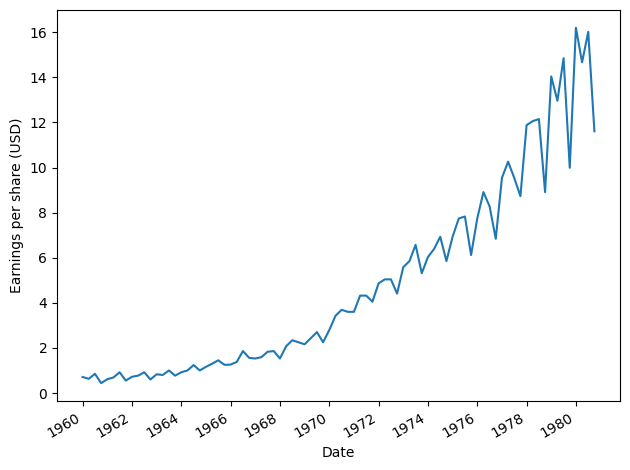

In [3]:
fig, ax = plt.subplots()

ax.plot(df.date, df['data'])
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

Since we have quarterly data, $m=4$.

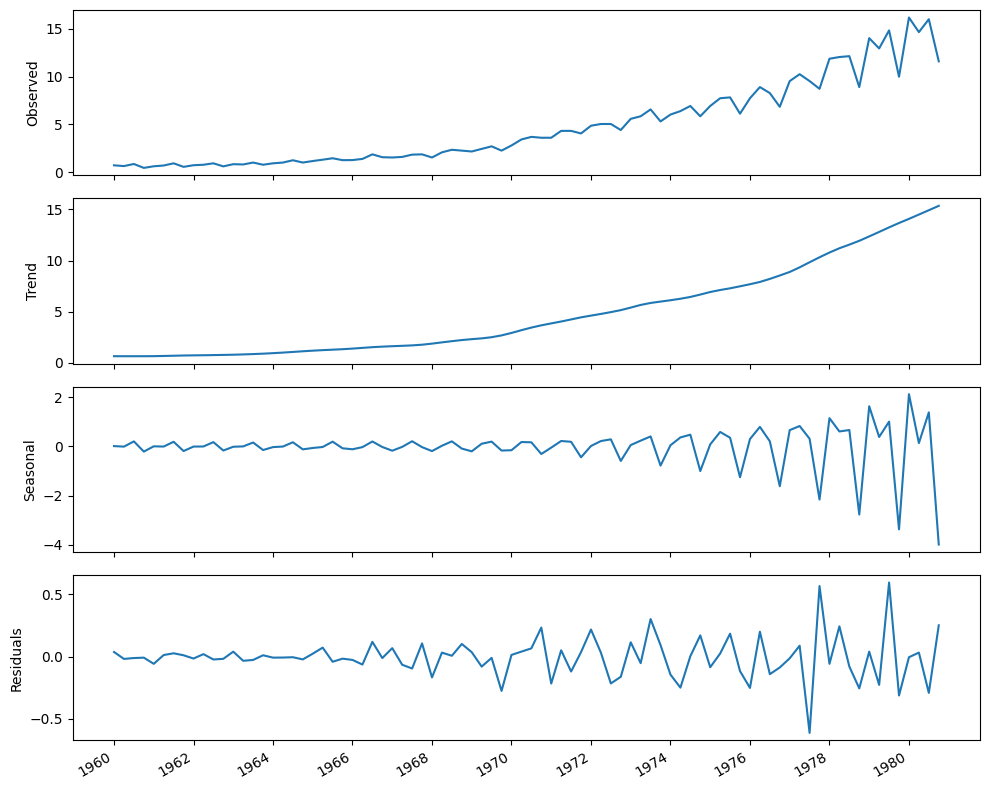

In [4]:
decomposition = STL(df['data'], period=4).fit()    # Period is 4 since we have quarterly data

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10,8))

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

In [5]:
ad_fuller_result = adfuller(df['data'])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 2.7420165734574735
p-value: 1.0


The series is not stationary, so let's apply differencing.

In [6]:
df_diff = np.diff(df['data'], n=1)

ad_fuller_result = adfuller(df_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -0.40740976363804116
p-value: 0.9088542416911313


The series is still not stationary. Let's try seasonal differencing now.

In [7]:
df_diff_seasonal_diff = np.diff(df_diff, n=4)

ad_fuller_result = adfuller(df_diff_seasonal_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -6.03249926264959
p-value: 1.4070571055692043e-07


The series is now statioanry. Therefore, we set $d=1$ and $D=1$.

In [8]:
def optimize_SARIMA(endog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(
                endog, 
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

Keep the last year to test the predictions.

In [9]:
train = df[:-4]
test = df[-4:]

In [10]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
Ps = range(0, 4, 1)
Qs = range(0, 4, 1)

SARIMA_order_list = list(product(ps, qs, Ps, Qs))

d = 1
D = 1
s = 4   # We have quarterly data, so 4 data points per seasonal cycle

SARIMA_result_df = optimize_SARIMA(train['data'], SARIMA_order_list, d, D, s)
SARIMA_result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(3, 0, 2, 1)",88.833028
1,"(1, 2, 0, 0)",89.609996
2,"(3, 1, 0, 0)",89.677549
3,"(1, 3, 0, 0)",89.734026
4,"(2, 2, 0, 0)",90.178107
...,...,...
251,"(0, 0, 3, 2)",136.748933
252,"(0, 0, 2, 3)",136.768806
253,"(0, 0, 0, 0)",137.133568
254,"(0, 0, 1, 3)",137.761947


The model with the lowest AIC is a $SARIMA(3,1,0)(2,1,1)_4$ model.

In [11]:
SARIMA_model = SARIMAX(train['data'], order=(3,1,0), seasonal_order=(2,1,1,4), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)

print(SARIMA_model_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                data   No. Observations:                   80
Model:             SARIMAX(3, 1, 0)x(2, 1, [1], 4)   Log Likelihood                 -37.417
Date:                             Tue, 10 Oct 2023   AIC                             88.833
Time:                                     14:08:39   BIC                            105.055
Sample:                                          0   HQIC                            95.310
                                              - 80                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8200      0.115     -7.154      0.000      -1.045      -0.595
ar.L2         -0.3655      

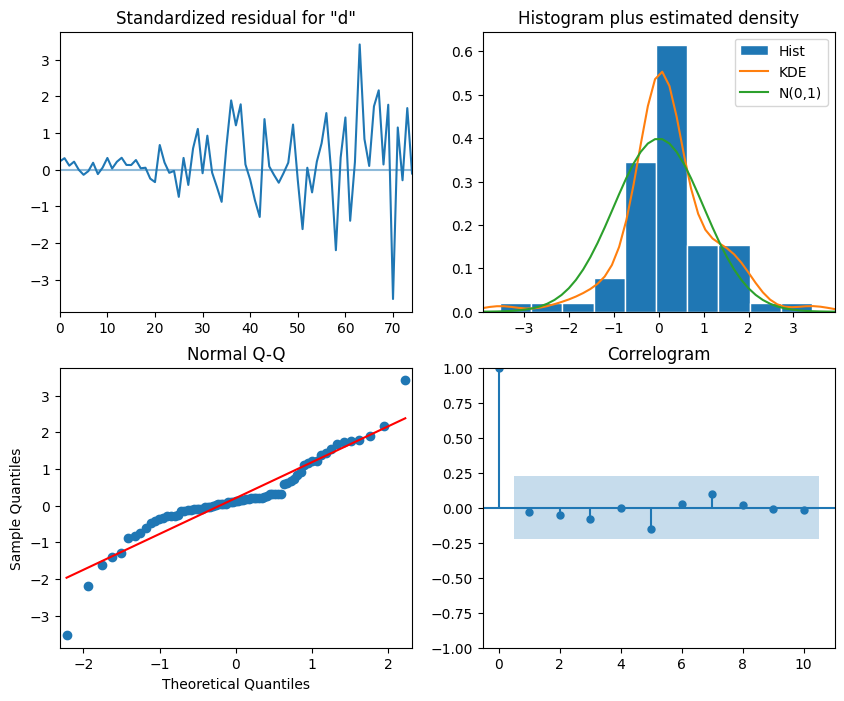

In [12]:
SARIMA_model_fit.plot_diagnostics(figsize=(10,8));

In [13]:
residuals = SARIMA_model_fit.resid

lbvalue, pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1))

print(pvalue)

lb_pvalue


In [14]:
SARIMA_pred = SARIMA_model_fit.get_prediction(80, 83).predicted_mean

test['SARIMA_pred'] = SARIMA_pred
test

,date,data,SARIMA_pred
80,1980-01-01,16.20,16.526230
81,1980-04-01,14.67,14.096940
82,1980-07-02,16.02,17.280178
83,1980-10-01,11.61,11.383205


In [15]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [16]:
mape_SARIMA = mape(test['data'], test['SARIMA_pred'])

print(mape_SARIMA)

3.934958406399473


In chapter 7, we achieved a MAPE of 2.85% with an ARIMA model, while the SARIMA model achieves a MAPE of 3.93%. In this case, the SARIMA model does not perform better on our test set. It can be interesting to have a larger test set and perform rolling forecasts to evaluate both models. However, our dataset is very limited.